# 1. SETUP AND LOAD DATA

1.1 Install dependencies and Setup

In [2]:
!pip list

Package                       Version
----------------------------- ------------
absl-py                       2.0.0
aiobotocore                   2.5.0
aiofiles                      22.1.0
aiohttp                       3.8.5
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
anaconda-anon-usage           0.4.2
anaconda-catalogs             0.2.0
anaconda-client               1.12.1
anaconda-cloud-auth           0.1.3
anaconda-navigator            2.5.1
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
applaunchservices             0.3.0
appnope                       0.1.2
appscript                     1.1.2
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse   

In [3]:
import tensorflow as tf
import os

In [4]:
# tf.config.list_physical_devices('GPU')

In [5]:
# # Avoid OOM errors by setting GPU Memory Consumption Growth

# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

1.2 Remove dodgy images

In [6]:
import cv2
import imghdr

/var/folders/9z/l6mn2w310rsgyf3z915fvg9c0000gn/T/ipykernel_18814/4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
data_dir = 'data'

In [8]:
os.listdir(data_dir) 

['happy', '.DS_Store', 'sad']

In [9]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [10]:
for image_class in os.listdir(data_dir):
    if image_class == '.DS_Store':
        continue
        
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

1.3 Load the data

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 208 files belonging to 2 classes.


In [13]:
data_iterator = data.as_numpy_iterator()

In [14]:
data_iterator

In [15]:
batch = data_iterator.next()

In [16]:
# Images represented as numpy arrays

batch[0].shape

(32, 256, 256, 3)

In [17]:
# Image labels

batch[1]

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1], dtype=int32)

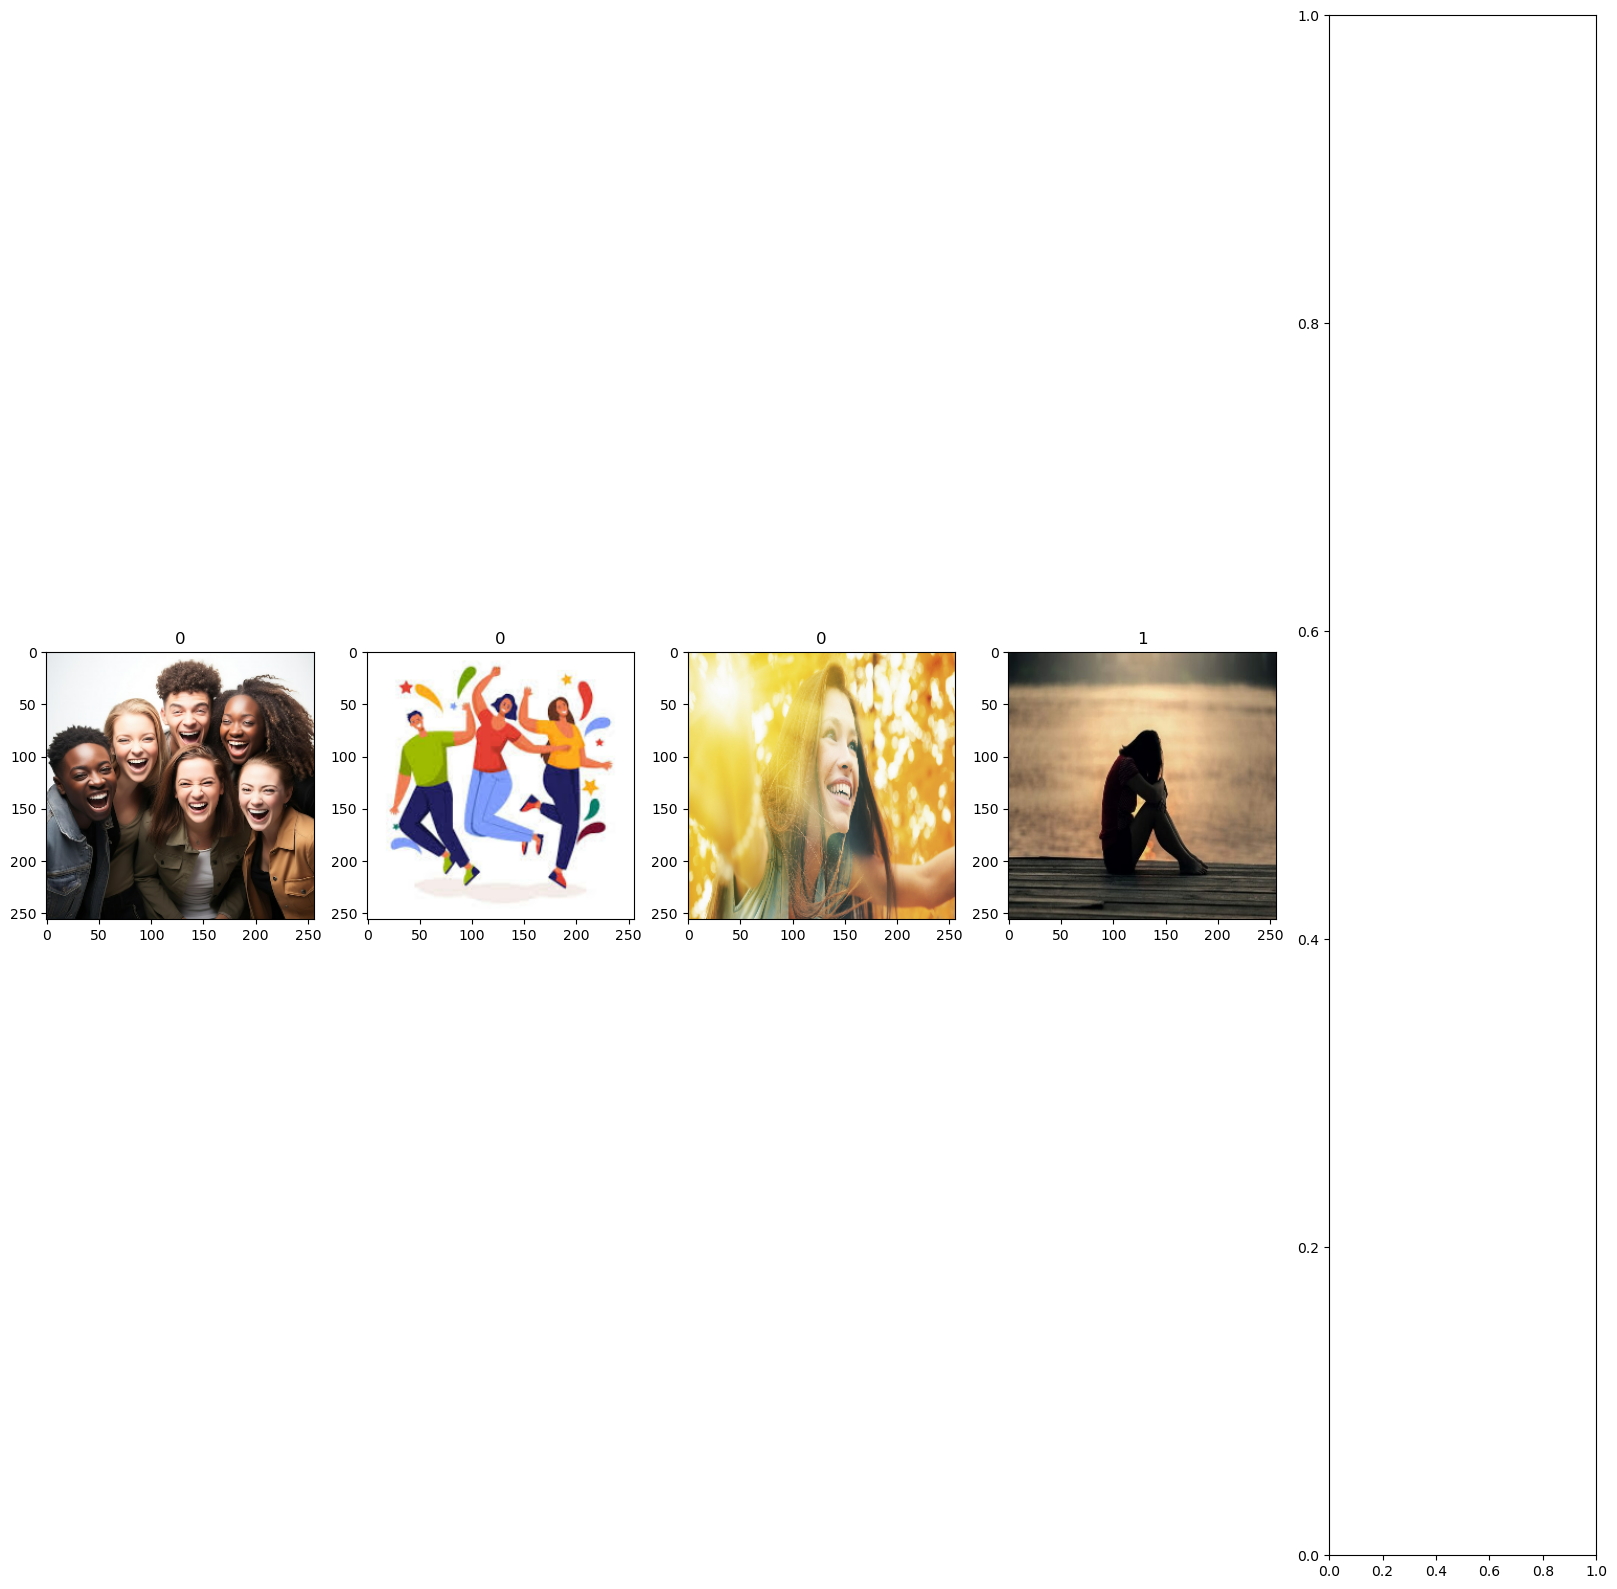

In [18]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))

for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## 2. PREPROCESS DATA

2.1 Scale Data

In [19]:
scaled_data = data.map(lambda x, y: (x/255, y))

In [20]:
scaled_iterator = scaled_data.as_numpy_iterator()

In [21]:
scaled_batch = scaled_iterator.next()

In [22]:
scaled_batch[0].max()

1.0

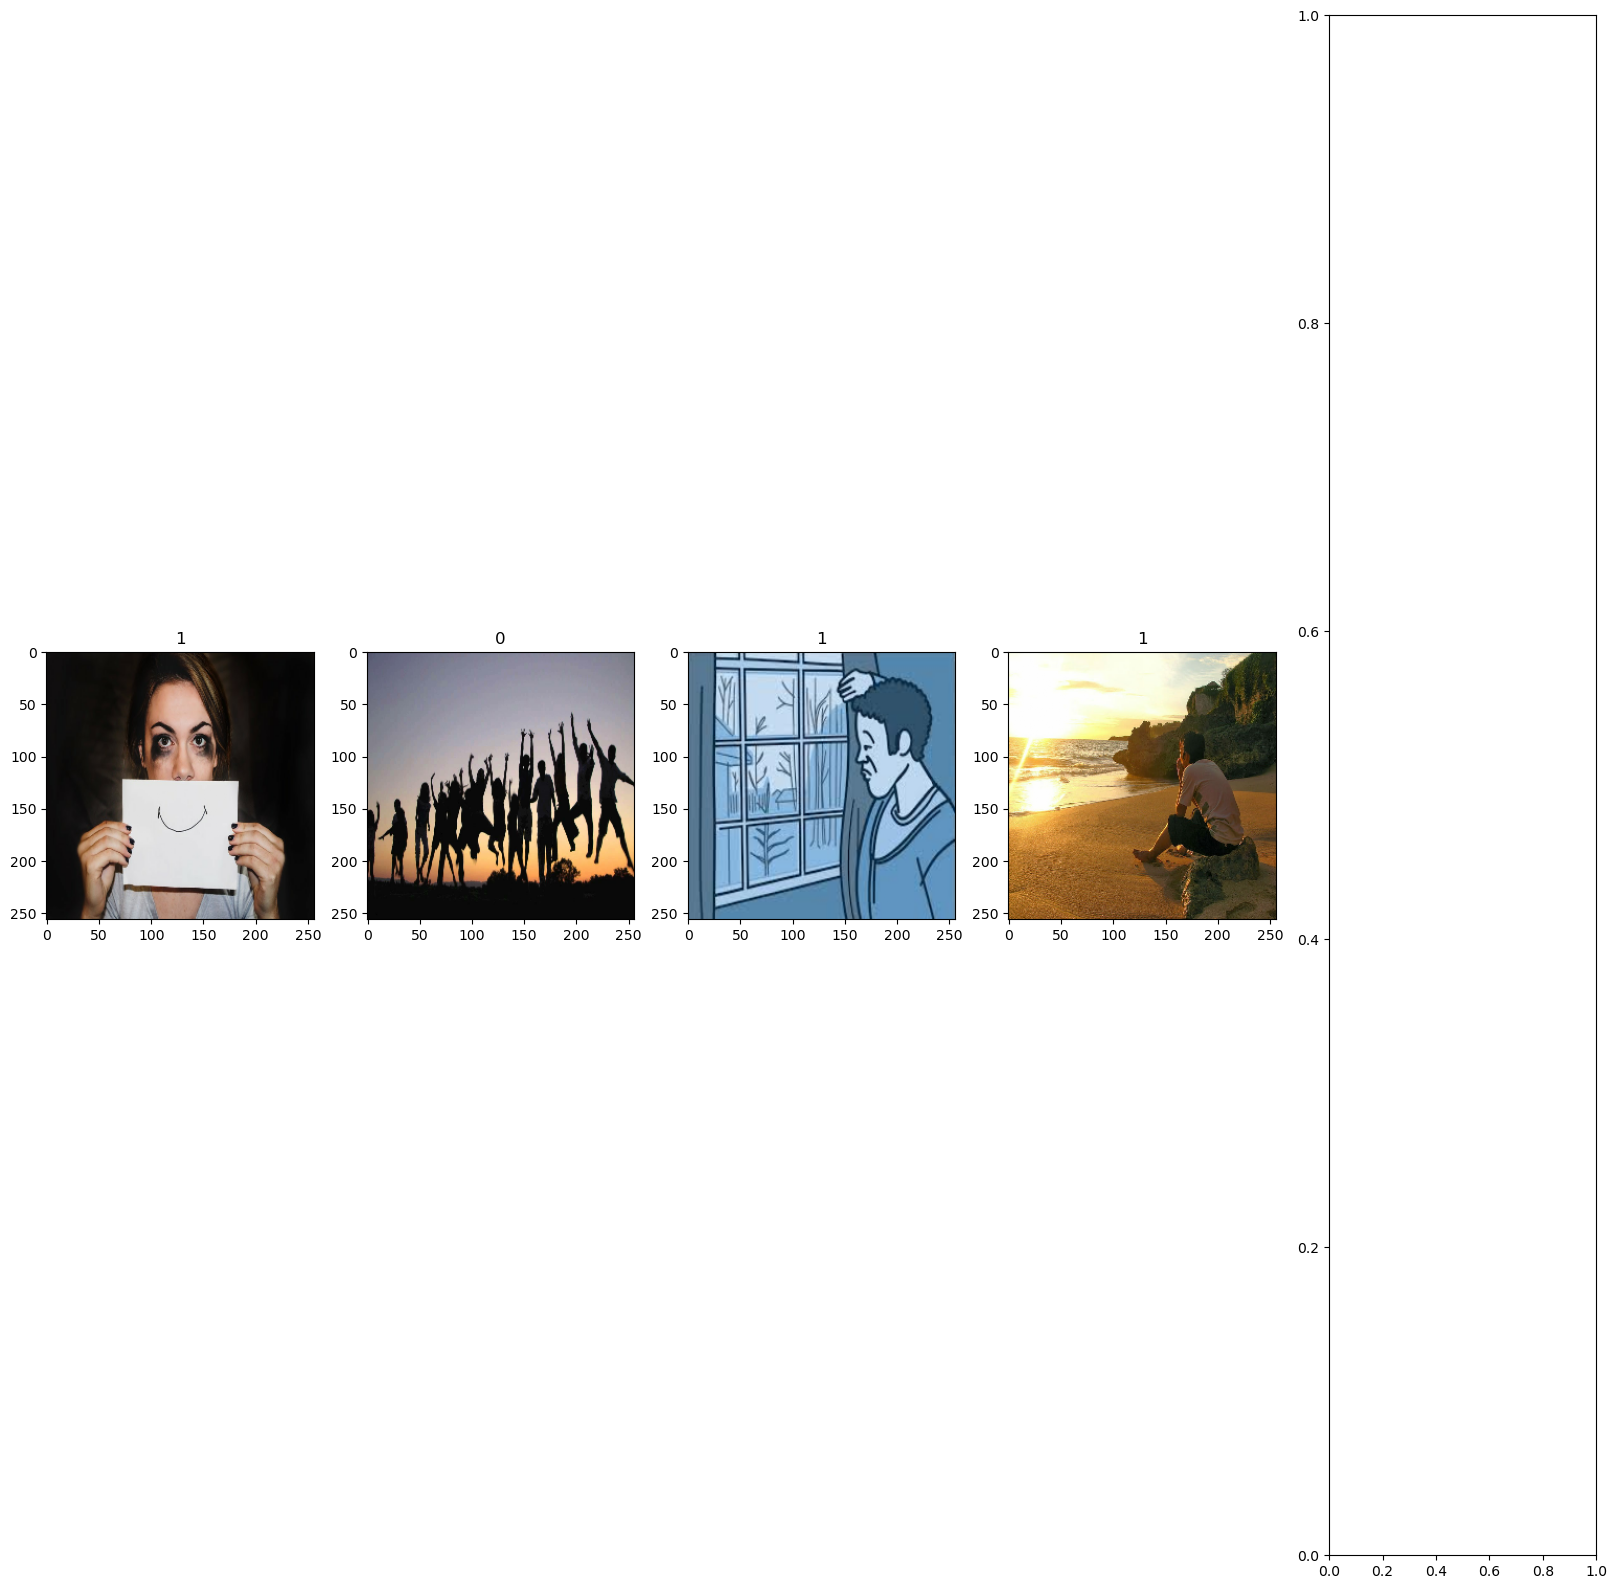

In [23]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))

for idx, img in enumerate(scaled_batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(scaled_batch[1][idx])

2.2 Split Data

In [24]:
# No. of batches in data
len(scaled_data)

7

In [25]:
train_size = int(len(scaled_data)*0.7)
val_size = int(len(scaled_data)*0.2)+1
test_size = int(len(scaled_data)*0.1)+1

In [26]:
train_size + val_size + test_size

7

In [27]:
train = scaled_data.take(train_size)
val = scaled_data.skip(train_size).take(val_size)
test = scaled_data.skip(train_size + val_size).take(test_size)

## Deep Model

3.1 Build Deep learning model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [29]:
model = Sequential()

In [30]:
#
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

3.2 Train the model

In [33]:
logdir='logs'

In [34]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [35]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 3s 553ms/step - loss: 1.2388 - accuracy: 0.4609 - val_loss: 0.6434 - val_accuracy: 0.6562
Epoch 2/20
4/4 [==============================] - 2s 506ms/step - loss: 0.7333 - accuracy: 0.5703 - val_loss: 0.6517 - val_accuracy: 0.5156
Epoch 3/20
4/4 [==============================] - 2s 510ms/step - loss: 0.6226 - accuracy: 0.7188 - val_loss: 0.5872 - val_accuracy: 0.8750
Epoch 4/20
4/4 [==============================] - 2s 509ms/step - loss: 0.5260 - accuracy: 0.7891 - val_loss: 0.5157 - val_accuracy: 0.6562
Epoch 5/20
4/4 [==============================] - 2s 513ms/step - loss: 0.5032 - accuracy: 0.7266 - val_loss: 0.4824 - val_accuracy: 0.6719
Epoch 6/20
4/4 [==============================] - 2s 509ms/step - loss: 0.4161 - accuracy: 0.7812 - val_loss: 0.4253 - val_accuracy: 0.8594
Epoch 7/20
4/4 [==============================] - 2s 498ms/step - loss: 0.3612 - accuracy: 0.8906 - val_loss: 0.2690 - val_accuracy: 0.9219
Epoch 8/20
4/4 [====

In [36]:
hist.history

{'loss': [1.2387785911560059,
  0.733329176902771,
  0.6226454973220825,
  0.5259571671485901,
  0.5031698942184448,
  0.41607406735420227,
  0.3612179756164551,
  0.2865588665008545,
  0.1864660382270813,
  0.14309807121753693,
  0.14698606729507446,
  0.05587111413478851,
  0.0593532919883728,
  0.03383789211511612,
  0.02383064292371273,
  0.022581148892641068,
  0.016749847680330276,
  0.02873510867357254,
  0.02654697373509407,
  0.06793861091136932],
 'accuracy': [0.4609375,
  0.5703125,
  0.71875,
  0.7890625,
  0.7265625,
  0.78125,
  0.890625,
  0.875,
  0.9375,
  0.953125,
  0.9375,
  0.9921875,
  0.9921875,
  0.9921875,
  1.0,
  0.9921875,
  1.0,
  0.9921875,
  1.0,
  0.96875],
 'val_loss': [0.6433853507041931,
  0.651698112487793,
  0.5871980786323547,
  0.5157147645950317,
  0.4824455976486206,
  0.42526328563690186,
  0.26902496814727783,
  0.1986897736787796,
  0.11145292222499847,
  0.10784279555082321,
  0.06746907532215118,
  0.06890899688005447,
  0.03197061270475387

3.3 Plot Performence

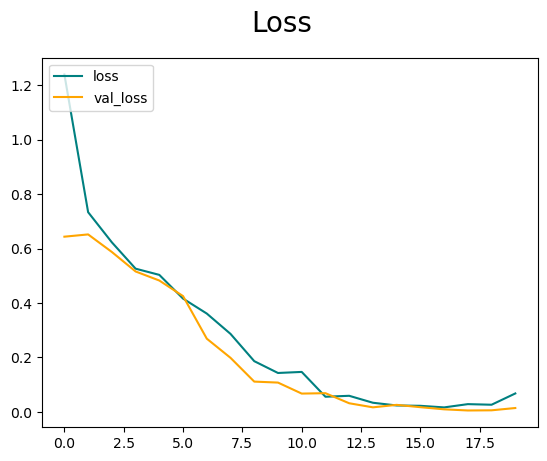

In [37]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

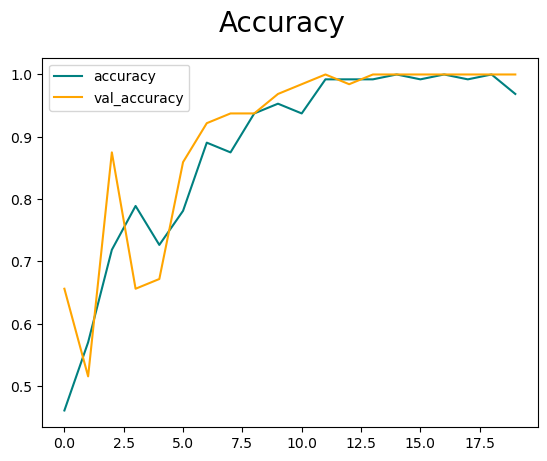

In [38]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Evaluate Performance

4.1 Evaluate

In [39]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [40]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [41]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 97ms/step


In [42]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


4.2 Test

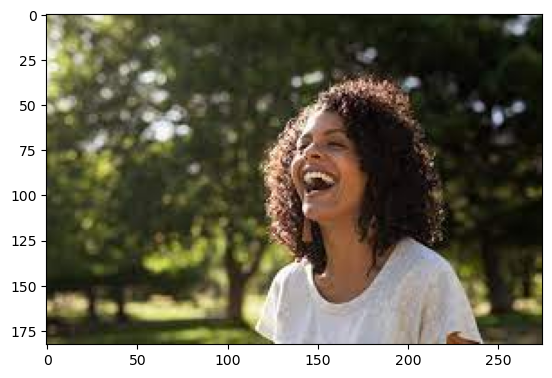

In [43]:
img = cv2.imread('happytest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

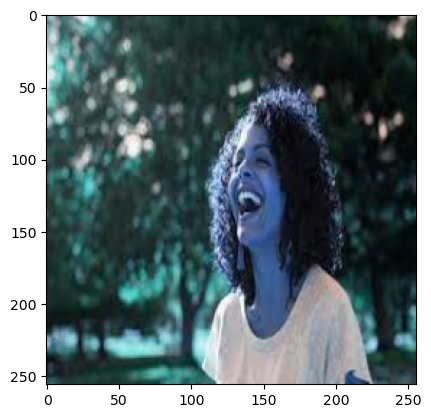

In [44]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [45]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 14ms/step


In [46]:
yhat

array([[0.11629328]], dtype=float32)

In [47]:
if yhat > 0.5:
    print('Predicted class is Sad.')
else:
    print('Predicted class is Happy.')

Predicted class is Happy.


## Save The Model

5.1 Save the Model

In [48]:
from tensorflow.keras.models import load_model

In [49]:
model.save(os.path.join('models', 'happysadmodel.h5'))

/Users/apple/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [50]:
new_model = load_model(os.path.join('models', 'happysadmodel.h5'))

In [51]:
new_model

In [52]:
yhat_new = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 32ms/step


In [53]:
yhat_new

array([[0.11629328]], dtype=float32)

In [54]:
if yhat_new > 0.5:
    print('Predicted class is Sad.')
else:
    print('Predicted class is Happy.')

Predicted class is Happy.
